In [27]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc
import seaborn as sns
import math

In [28]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [29]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [30]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [31]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [32]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [33]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [34]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [35]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [36]:
to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

columns_to_save = ['event', 'dataset', 'mag', 'interp_momentrate']
df_interp = pd.DataFrame(columns = columns_to_save)
max_len = 0
for i, row in combined.iterrows():
	# if i < 360:
	# 	continue

	#fig, axs = plt.subplots(2, 1, figsize=(10, 10))


	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):
		if dataset != 'usgs':
			continue
		if dataset == 'scardec_moy' or dataset == 'scardec_opt':
			name = row[dataset[:-4]]
		else:
			name = row[dataset]

		if name == '0' or name == 0:
			continue

		if dataset == 'scardec_moy':
			momentrate, time = get_stf(name, 'fctmoy')
		elif dataset == 'scardec_opt':
			momentrate, time = get_stf(name, 'fctopt')
		else:
			momentrate, time = get_stf(name)

		if dataset != 'sigloch':
			momentrate_list = [momentrate]
			time_list = [time]
		else:
			momentrate_list = momentrate
			time_list = time

		count = 0
		for momentrate, time in zip(momentrate_list, time_list):
			if time[0] == time[1]:
				time = time[1:]

			if dataset != 'sigloch':
				save_key = row.event
				dataset_name = dataset
			else:
				dataset_name = dataset + '_' + str(count)
				save_key = row.event + '_' + str(count)

			if save_key in to_ignore:
				continue
			#print(time[0:10])
			
			momentrate = np.array(momentrate)

			time = np.array(time)
			detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
			time = time[detected_start:detected_end] # shift to start STF at zero
			time = time - time[0]
			momentrate = momentrate[detected_start:detected_end]
			max_len = max(max_len, len(momentrate))
			norm_momentrate = momentrate / max(momentrate)
			norm_time = time / max(time)
			#axs[0].plot(norm_time, norm_momentrate)

			interp_momentrate = np.interp(np.linspace(0, 1, 10000), norm_time, norm_momentrate)
			interp_momentrate[interp_momentrate < 0] = 0

			#axs[1].plot(np.linspace(0, 1, 100), interp_momentrate)

			df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, interp_momentrate]], columns = columns_to_save)], ignore_index = True)
			count += 1
	#plt.show()
	#plt.close()
	# if i > 361:
	# 	break
	# 	break


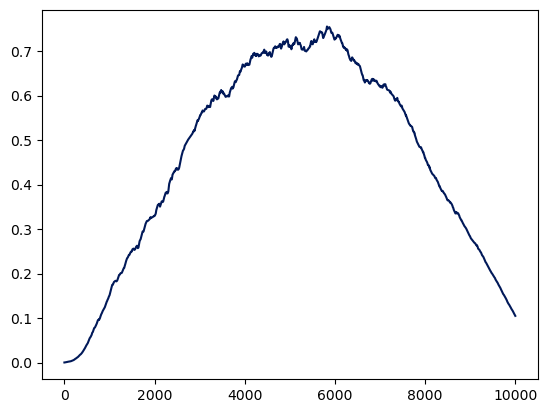

In [37]:
interval = 6
boundaries = [5] #np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'
	plt.plot(np.median(list(subset), axis = 0), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker)


	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

	#plt.show()
#plt.legend()

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_only_every_01_nolegend.png')



In [38]:
y = np.median(list(subset), axis = 0)
x = np.linspace(0, 1, len(y))

Segment 0: Slope = 1.5939217081596233, Intercept = -0.025894360625853968
Segment 1: Slope = 1.8119732542884983, Intercept = -0.023312437343358073
Segment 2: Slope = 2.2577669969696625, Intercept = -0.12417617703287623
Segment 3: Slope = 0.9941831062341951, Intercept = 0.25711855290858093
Segment 4: Slope = 0.473764569072968, Intercept = 0.48433845959193556
Segment 5: Slope = 0.40056472457480063, Intercept = 0.5038889821457817
Segment 6: Slope = -1.2443960646507843, Intercept = 1.4794912844282815
Segment 7: Slope = -1.718127526149535, Intercept = 1.8479216023609843
Segment 8: Slope = -1.6819010497714713, Intercept = 1.7985236248508878
Segment 9: Slope = -1.8126392488436445, Intercept = 1.9191049016400248


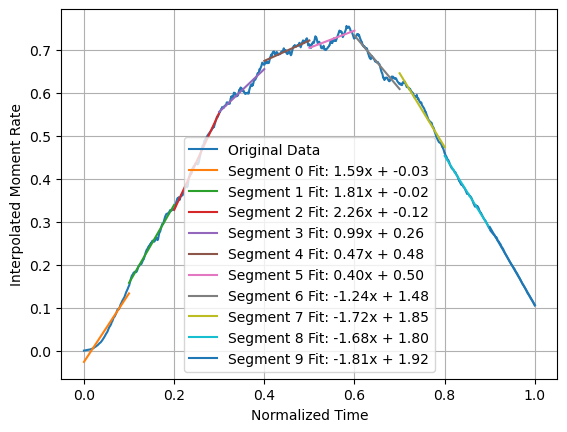

In [39]:
segment_length = 1000  # Define the length of each segment
num_segments = len(y) // segment_length

slopes = []
intercepts = []

for i in range(num_segments):
	start = i * segment_length
	end = start + segment_length
	segment_x = x[start:end]
	segment_y = y[start:end]
	
	# Fit a straight line to the segment
	slope, intercept = np.polyfit(segment_x, segment_y, 1)
	slopes.append(slope)
	intercepts.append(intercept)

# Print the slopes and intercepts of each segment
for i, (slope, intercept) in enumerate(zip(slopes, intercepts)):
	print(f"Segment {i}: Slope = {slope}, Intercept = {intercept}")

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the fitted lines for each segment
for i in range(num_segments):
	start = i * segment_length
	end = start + segment_length
	segment_x = x[start:end]
	segment_y = slopes[i] * segment_x + intercepts[i]
	plt.plot(segment_x, segment_y, label=f'Segment {i} Fit: {slopes[i]:.2f}x + {intercepts[i]:.2f}')
plt.grid()
plt.xlabel('Normalized Time')
plt.ylabel('Interpolated Moment Rate')
plt.legend()
plt.show()

In [40]:

x[np.argmax(y)]

0.5823582358235824

Segment 0: Slope = 1.8857669053720325, Intercept = -0.03742619405448094
Segment 1: Slope = 1.6428096491282764, Intercept = 0.02982838886153028
Segment 2: Slope = 0.473764569072968, Intercept = 0.48433845959193556
Segment 3: Slope = -0.18402065443681367, Intercept = 0.8085163160066947
Segment 4: Slope = 0.43765425329426727, Intercept = 0.4848436766625961
Segment 5: Slope = -1.2443960646507843, Intercept = 1.4794912844282815
Segment 6: Slope = -1.802976157463438, Intercept = 1.9076421438873994


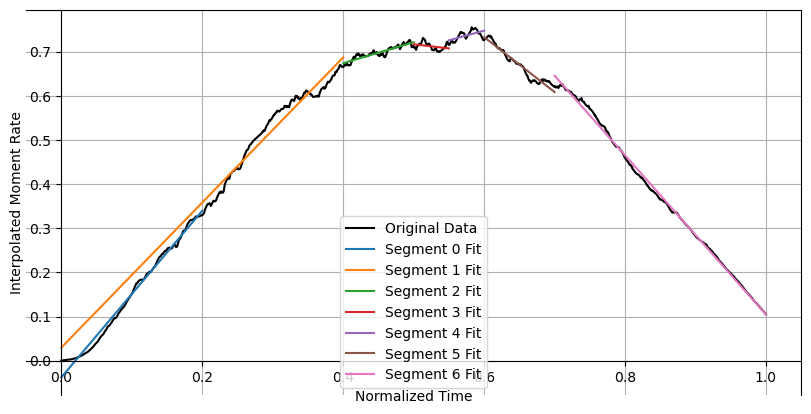

In [41]:
segment_boundaries = [0, 0.2, 0.4, 0.5, 0.55, 0.6, 0.7, 1.0]  # Define the boundaries of each segment
num_segments = len(segment_boundaries) - 1

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
ax = axs

slopes = []
intercepts = []

for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	segment_y = y[start:end]
	
	# Fit a straight line to the segment
	slope, intercept = np.polyfit(segment_x, segment_y, 1)
	slopes.append(slope)
	intercepts.append(intercept)

# Print the slopes and intercepts of each segment
for i, (slope, intercept) in enumerate(zip(slopes, intercepts)):
	print(f"Segment {i}: Slope = {slope}, Intercept = {intercept}")

# Plot the original data
ax.plot(x, y, label='Original Data', color = 'k')

# Plot the fitted lines for each segment
for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	if i == 1:
		segment_x = x[0:end]
	segment_y = slopes[i] * segment_x + intercepts[i]
	ax.plot(segment_x, segment_y, label=f'Segment {i} Fit')#, marker = '.')

#ax.hlines(0, 0, 1, color = 'k')
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Interpolated Moment Rate')
ax.legend(loc = 'lower center')
#ax.set_aspect('equal')
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

#sns.despine(ax=ax, offset=0) # the important part here
plt.show()

Segment 0: Slope = 1.8857669053720325, Intercept = -0.03742619405448094
Segment 1: Slope = 1.6428096491282764, Intercept = 0.02982838886153028
Segment 2: Slope = 0.26132291684219405, Intercept = 0.5781940363925077
Segment 3: Slope = -0.9380685715304081, Intercept = 1.278880752315357
Segment 4: Slope = -1.802976157463438, Intercept = 1.9076421438873994


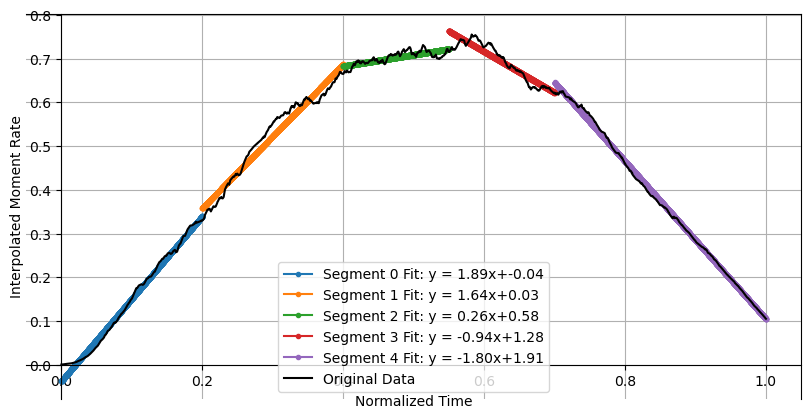

In [42]:
segment_boundaries = [0, 0.2, 0.4, 0.55, 0.7, 1.0]  # Define the boundaries of each segment
num_segments = len(segment_boundaries) - 1

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
ax = axs

slopes = []
intercepts = []

for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	segment_y = y[start:end]
	
	# Fit a straight line to the segment
	slope, intercept = np.polyfit(segment_x, segment_y, 1)
	slopes.append(slope)
	intercepts.append(intercept)

# Print the slopes and intercepts of each segment
for i, (slope, intercept) in enumerate(zip(slopes, intercepts)):
	print(f"Segment {i}: Slope = {slope}, Intercept = {intercept}")

# Plot the original data


# Plot the fitted lines for each segment
for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	segment_y = slopes[i] * segment_x + intercepts[i]
	ax.plot(segment_x, segment_y, label=f'Segment {i} Fit: y = {slopes[i]:.2f}x+{intercepts[i]:.2f}', marker = '.')
	# if i == 1:
		# segment_x = x[0:end]
		# segment_y = slopes[i] * segment_x + intercepts[i]
		# ax.plot(segment_x, segment_y, label=f'Segment {i} 2')#, marker = '.')

ax.plot(x, y, label='Original Data', color = 'k')
#ax.hlines(0, 0, 1, color = 'k')
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Interpolated Moment Rate')
ax.legend(loc = 'lower center')
#ax.set_aspect('equal')
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

#sns.despine(ax=ax, offset=0) # the important part here
plt.show()

Segment 0: Slope = 1.877187539760885, Intercept = -0.03691832266958724
Segment 1: Slope = 1.7385025273232813, Intercept = -0.0013528615059176178
Segment 2: Slope = -0.13331631345632775, Intercept = 0.7707736073486753
Segment 3: Slope = -1.802976157463438, Intercept = 1.9076421438873994


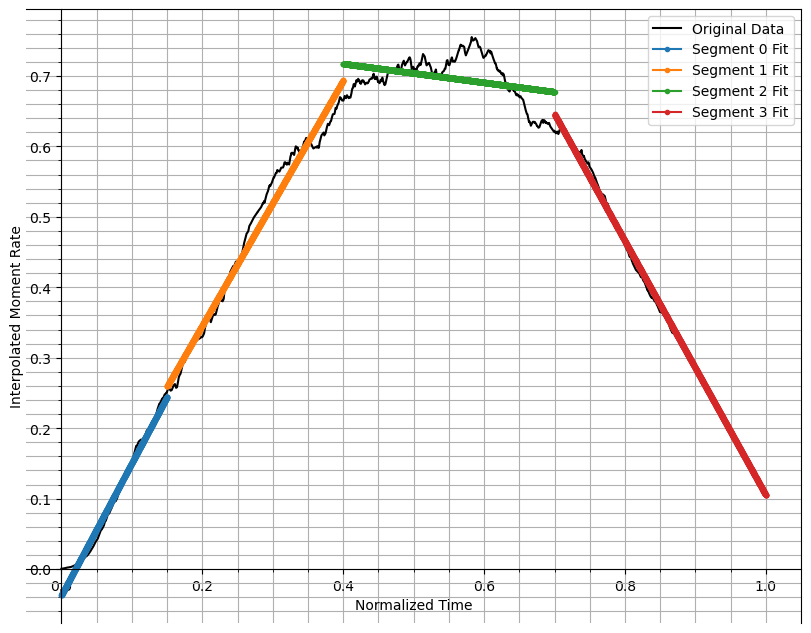

In [43]:
segment_boundaries = [0, 0.15, 0.4, 0.7, 1.0]  # Define the boundaries of each segment
num_segments = len(segment_boundaries) - 1

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
ax = axs

slopes = []
intercepts = []

for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	segment_y = y[start:end]
	
	# Fit a straight line to the segment
	slope, intercept = np.polyfit(segment_x, segment_y, 1)
	slopes.append(slope)
	intercepts.append(intercept)

# Print the slopes and intercepts of each segment
for i, (slope, intercept) in enumerate(zip(slopes, intercepts)):
	print(f"Segment {i}: Slope = {slope}, Intercept = {intercept}")

# Plot the original data
ax.plot(x, y, label='Original Data', color = 'k')

# Plot the fitted lines for each segment
for i in range(num_segments):
	start = int(segment_boundaries[i] * len(x))
	end = int(segment_boundaries[i + 1] * len(x))
	segment_x = x[start:end]
	segment_y = slopes[i] * segment_x + intercepts[i]
	ax.plot(segment_x, segment_y, label=f'Segment {i} Fit', marker = '.')
	# if i == 1:
	# 	segment_x = x[0:end]
	# 	segment_y = slopes[i] * segment_x + intercepts[i]
	# 	ax.plot(segment_x, segment_y, label=f'Segment {i} 2')#, marker = '.')

#ax.hlines(0, 0, 1, color = 'k')
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Interpolated Moment Rate')
ax.legend(loc = 'upper right')
ax.minorticks_on()
ax.set_aspect('equal')
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

#sns.despine(ax=ax, offset=0) # the important part here
plt.show()

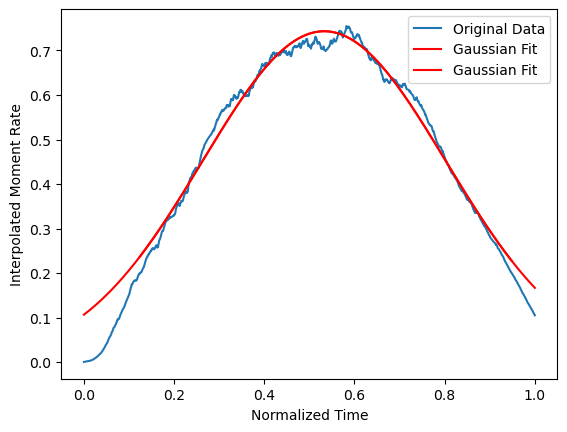

Amplitude: 0.7432200125019608, Mean: 0.5327347223313768, Standard Deviation: 0.27030869426119986


In [44]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, amp, mean, stddev):
	return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Filter the data to include only y values above 0.2
filtered_indices = y > 0.2
filtered_x = x[filtered_indices]
filtered_y = y[filtered_indices]

# Initial guess for the parameters
initial_guess = [1, np.mean(filtered_x), np.std(filtered_x)]

# Fit the Gaussian function to the filtered data
popt, pcov = curve_fit(gaussian, filtered_x, filtered_y, p0=initial_guess)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the Gaussian fit
plt.plot(filtered_x, gaussian(filtered_x, *popt), label='Gaussian Fit', color='red')
plt.plot(x, gaussian(x, *popt), label='Gaussian Fit', color='red')


plt.xlabel('Normalized Time')
plt.ylabel('Interpolated Moment Rate')
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Amplitude: {popt[0]}, Mean: {popt[1]}, Standard Deviation: {popt[2]}")
#

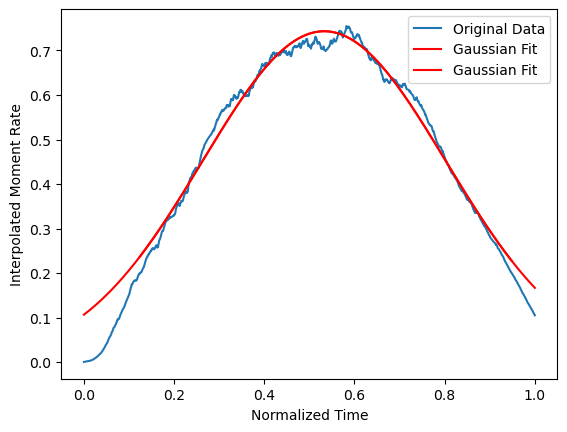

Amplitude: 0.7432200125019608, Mean: 0.5327347223313768, Standard Deviation: 0.27030869426119986


In [45]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, amp, mean, stddev):
	return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Filter the data to include only y values above 0.2
filtered_indices = y > 0.2
filtered_x = x[filtered_indices]
filtered_y = y[filtered_indices]

# Initial guess for the parameters
initial_guess = [1, np.mean(filtered_x), np.std(filtered_x)]

# Fit the Gaussian function to the filtered data
popt, pcov = curve_fit(gaussian, filtered_x, filtered_y, p0=initial_guess)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the Gaussian fit
plt.plot(filtered_x, gaussian(filtered_x, *popt), label='Gaussian Fit', color='red')
plt.plot(x, gaussian(x, *popt), label='Gaussian Fit', color='red')


plt.xlabel('Normalized Time')
plt.ylabel('Interpolated Moment Rate')
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Amplitude: {popt[0]}, Mean: {popt[1]}, Standard Deviation: {popt[2]}")
#

In [46]:
popt

array([0.74322001, 0.53273472, 0.27030869])

In [47]:
def gaussian(x, amp=1, mean=0.5, stddev=1):
	return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [48]:
def triangle(x, center = 0.5, peak = 1, start = 0, end = 1):
	#start is x value where y = 0
	#end is x value where y = 0

    x = np.array(x)
    dx = 1/len(x)
    y = np.zeros(len(x))

    left_m = peak/(center-start)
    right_m = peak/(end-center)

    #print(left_m, right_m)

    y[int(start/dx):int(center/dx)] = left_m*x[int(start/dx):int(center/dx)]
    y[int(start/dx):int(center/dx)] = y[int(start/dx):int(center/dx)] - y[int(start/dx)]
    y[int(center/dx):int(end/dx)] = -right_m*x[int(center/dx):int(end/dx)]
    y[int(center/dx):int(end/dx)] = y[int(center/dx):int(end/dx)] + abs(y[int(center/dx)]) + peak
    #print(y[int(len(x)*((end-center)/(end-start)))])
    # y[:int(len(right_m)] = y[:int(len(right_m)] - min(y[:int(len(x)/2)])
    # y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [49]:
def boxcar(x, start=0, end=0, peak=1):
    length = len(x)
    start_index = int(start*len(x))
    end_index = int(end*len(x))
    y = np.zeros(len(x))
    y[start_index:length-end_index] = peak

    return y

In [50]:
def trapezium(x, start = 0.3333, end = 0.3333, peak = 1, start_height = 0, end_height = 0):

    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    #print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(start_height, peak, start_index)
    y[start_index:length-end_index] = peak
    y[length-end_index:] = peak - np.linspace(end_height, peak, end_index) + end_height
    return y


In [51]:
def sine_boxcar(x, start = 0.3333, end = 0.3333, peak = 1, start_height = 0, end_height = 0):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    #print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))+1)*((peak-start_height)/2)+start_height
    y[start_index:length-end_index] = peak
    y[length-end_index:] = ((np.sin(np.linspace(-math.pi/2, math.pi/2, end_index)))[::-1]+1)*((peak-end_height)/2)+end_height
    return y

# find best fitting curves

In [52]:
x = np.linspace(0, 1, 10000)
styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]

obs_y = np.median(list(subset), axis = 0)
obs_x = np.linspace(0, 1, len(subset[0]))

### trapezium

In [53]:
left_flat_list = []
right_flat_list = []
height_list = []
start_height_list = []
end_height_list = []
sum_list = []


for left_flat in np.linspace(0.3, 0.5, 20):
	for right_flat in np.linspace(0.4, 0.7, 20):
		for height in np.linspace(0.7, 0.9, 20):
			for start_height in np.linspace(0, 0.15, 20):
				for end_height in np.linspace(0, 0.3, 20):
					trap_y = trapezium(x, left_flat, 1-right_flat, height, start_height = start_height, end_height = end_height)
					sum_list.append(np.sum((trap_y - obs_y)**2))
					left_flat_list.append(left_flat)
					right_flat_list.append(right_flat)
					height_list.append(height)
					start_height_list.append(start_height)
					end_height_list.append(end_height)
					

In [54]:
trap_df = pd.DataFrame({'left_flat': left_flat_list, 'right_flat': right_flat_list, 'height': height_list, 'start_height': start_height_list, 'end_height': end_height_list, 'r2': sum_list})

In [55]:
trap_df.sort_values('r2').head(10)
best_trap_left_flat = trap_df.sort_values('r2').head(1).left_flat.values[0]
best_trap_right_flat = trap_df.sort_values('r2').head(1).right_flat.values[0]
best_trap_height = trap_df.sort_values('r2').head(1).height.values[0]
best_trap_start_height = trap_df.sort_values('r2').head(1).start_height.values[0]
best_trap_end_height = trap_df.sort_values('r2').head(1).end_height.values[0]


### triangle

In [56]:
center_list = []
height_list = []
start_posn_list = []
end_posn_list = []
sum_list = []

for center in np.linspace(0.3, 0.7, 20):
	for height in np.linspace(0.7, 0.9, 20):
		for start_posn in np.linspace(-0.4, 0.4, 20):
			for end_posn in np.linspace(0.6, 1.4, 20):
				tri_y = triangle(x, center = center, peak = height, start = start_posn, end = end_posn)
				sum_list.append(np.sum((tri_y - obs_y)**2))
				center_list.append(center)
				height_list.append(height)
				start_posn_list.append(start_posn)
				end_posn_list.append(end_posn)
				
					

In [57]:
tri_df = pd.DataFrame({'center': center_list, 'height': height_list, 'start_posn': start_posn_list, 'end_posn': end_posn_list, 'r2': sum_list})

In [58]:
tri_df.sort_values('r2').head(10)
best_tri_center = tri_df.sort_values('r2').head(1).center.values[0]
best_tri_height = tri_df.sort_values('r2').head(1).height.values[0]
best_tri_start = tri_df.sort_values('r2').head(1).start_posn.values[0]
best_tri_end = tri_df.sort_values('r2').head(1).end_posn.values[0]


### boxcar

In [59]:
start_list = []
end_list = []
height_list = []
sum_list = []

for start in np.linspace(0., 0.5, 20):
	for end in np.linspace(0., 0.5, 20):
		for height in np.linspace(0.7, 1, 20):
			box_y = boxcar(x, start = start, end = end, peak = height)
			sum_list.append(np.sum((box_y - obs_y)**2))
			start_list.append(start)
			height_list.append(height)
			end_list.append(end)
			
					

In [60]:
boxcar_df = pd.DataFrame({'start': start_list, 'end': end_list, 'height': height_list, 'r2': sum_list})

In [61]:
boxcar_df.sort_values('r2').head(10)
best_box_height = boxcar_df.sort_values('r2').head(1).height.values[0]
best_box_start = boxcar_df.sort_values('r2').head(1).start.values[0]
best_box_end = boxcar_df.sort_values('r2').head(1).end.values[0]




### sine boxcar

In [ ]:
start_list = []
end_list = []
height_list = []
start_height_list = []
end_height_list = []
sum_list = []

for start in np.linspace(0., 1, 20):
	for end in np.linspace(0., 1, 20):
		for height in np.linspace(0.7, 1, 20):
			for start_height in np.linspace(0, 0.15, 20):
				for end_height in np.linspace(0, 0.3, 20):
					sinebox_y = sine_boxcar(x, start = start, end = end, peak = height)
					sum_list.append(np.sum((sinebox_y - obs_y)**2))
					start_list.append(start)
					height_list.append(height)
					end_list.append(end)
					start_height_list.append(start_height)
					end_height_list.append(end_height)
			
					

In [63]:
sineboxcar_df = pd.DataFrame({'start': start_list, 'end': end_list, 'height': height_list, 'start_height': start_height_list, 'end_height': end_height_list, 'r2': sum_list})

In [64]:
sineboxcar_df.sort_values('r2').head(10)
best_sinebox_height = sineboxcar_df.sort_values('r2').head(1).height.values[0]
best_sinebox_start = sineboxcar_df.sort_values('r2').head(1).start.values[0]
best_sinebox_end = sineboxcar_df.sort_values('r2').head(1).end.values[0]
best_sinebox_start_height = sineboxcar_df.sort_values('r2').head(1).start_height.values[0]
best_sinebox_end_height = sineboxcar_df.sort_values('r2').head(1).end_height.values[0]



In [65]:
sineboxcar_df.sort_values('r2').head(10)

,start,end,height,start_height,end_height,r2
2656398,0.421053,0.315789,0.7,0.150000,0.284211,36.866929
2656126,0.421053,0.315789,0.7,0.047368,0.094737,36.866929
2656127,0.421053,0.315789,0.7,0.047368,0.110526,36.866929
2656128,0.421053,0.315789,0.7,0.047368,0.126316,36.866929
2656129,0.421053,0.315789,0.7,0.047368,0.142105,36.866929
2656130,0.421053,0.315789,0.7,0.047368,0.157895,36.866929
2656131,0.421053,0.315789,0.7,0.047368,0.173684,36.866929
2656132,0.421053,0.315789,0.7,0.047368,0.189474,36.866929
2656133,0.421053,0.315789,0.7,0.047368,0.205263,36.866929
2656134,0.421053,0.315789,0.7,0.047368,0.221053,36.866929


### gaussian

In [66]:
gaussian(x, amp=1, mean=0.5, stddev=1)

array([0.8824969 , 0.88254103, 0.88258515, ..., 0.88258515, 0.88254103,
       0.8824969 ])

In [ ]:
amp_list = []
mean_list = []
std_list = []
sum_list = []

for mean in np.linspace(0., 1, 100):
	for std in np.linspace(0., 5, 100):
		for height in np.linspace(0, 1, 100):
			gauss_y = gaussian(x, amp = height, mean = mean, stddev = std)
			sum_list.append(np.sum((gauss_y - obs_y)**2))
			amp_list.append(height)
			mean_list.append(mean)
			std_list.append(std)
			
					

/tmp/ipykernel_1152209/1530956706.py:2: RuntimeWarning: divide by zero encountered in divide
  return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
/tmp/ipykernel_1152209/1530956706.py:2: RuntimeWarning: invalid value encountered in divide
  return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))


In [68]:
gaussian_df = pd.DataFrame({'mean_val': mean_list, 'std_val': std_list, 'height_val': amp_list, 'r2': sum_list})

In [69]:
gaussian_df.sort_values('r2').head(10)
best_gauss_height = gaussian_df.sort_values('r2').head(1).height_val.values[0]
best_gauss_mean = gaussian_df.sort_values('r2').head(1).mean_val.values[0]
best_gauss_std = gaussian_df.sort_values('r2').head(1).std_val.values[0]



In [70]:
gaussian_df.sort_values('r2').head(10)

,mean_val,std_val,height_val,r2
4034,0.526316,0.263158,0.736842,14.475119
4035,0.526316,0.263158,0.789474,22.607965
4033,0.526316,0.263158,0.684211,31.979758
4434,0.578947,0.263158,0.736842,43.318239
4435,0.578947,0.263158,0.789474,52.549983
4036,0.526316,0.263158,0.842105,56.378296
4433,0.578947,0.263158,0.684211,59.595802
4032,0.526316,0.263158,0.631579,75.121881
3634,0.473684,0.263158,0.736842,82.728560
4436,0.578947,0.263158,0.842105,87.291036


## draw best fitting curves


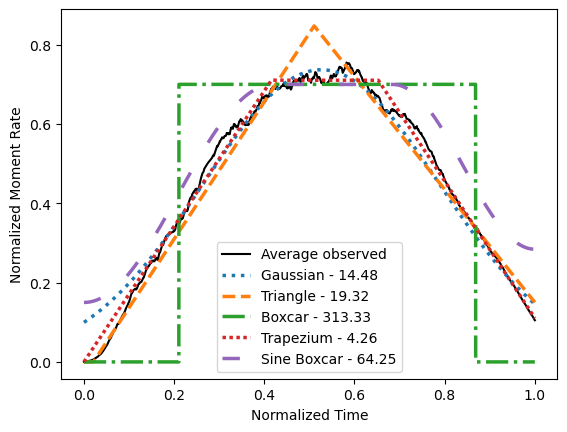

In [71]:
x = np.linspace(0, 1, 10000)
styles = ['dotted', 'dashed',  'dashdot', (0, (1, 1)), (0, (5, 10))]

obs_y = np.median(list(subset), axis = 0)
obs_x = np.linspace(0, 1, len(subset[0]))
plt.plot(obs_x, obs_y, label = 'Average observed', color = 'k')

gaussian_y = gaussian(x, amp = best_gauss_height, mean = best_gauss_mean, stddev = best_gauss_std)
plt.plot(x, gaussian_y, label = f'Gaussian - {np.sum((gaussian_y - obs_y)**2):.2f}', linestyle=styles.pop(0), linewidth = 2.5)

triangle_y = triangle(x, center = best_tri_center, peak = best_tri_height, start = best_tri_start, end = best_tri_end)
#triangle_y[0: int(0.14*len(x))] = 1.13*x[0:int(0.14*len(x))] + 0.03
plt.plot(x, triangle_y, label = f'Triangle - {np.sum((triangle_y - obs_y)**2):.2f}', linestyle=styles.pop(0), linewidth = 2.5)

boxcar_y = boxcar(x, start = best_box_start, end = best_box_end, peak = best_box_height)
plt.plot(x, boxcar_y, label = f'Boxcar - {np.sum((boxcar_y - obs_y)**2):.2f}', linestyle=styles.pop(0), linewidth = 2.5)

trap_y = trapezium(x, best_trap_left_flat, 1-best_trap_right_flat, best_trap_height, start_height = best_trap_start_height, end_height = best_trap_end_height)
#trap_y[0: int(0.14*len(x))] = 1.13*x[0:int(0.14*len(x))] + 0.03
plt.plot(x, trap_y, label = f'Trapezium - {np.sum((trap_y - obs_y)**2):.2f}', linestyle=styles.pop(0), linewidth = 2.5)

sine_boxcar_y = sine_boxcar(x, start = best_sinebox_start, end = best_sinebox_end, peak = best_sinebox_height, start_height = best_sinebox_start_height, end_height = best_sinebox_end_height)
plt.plot(x, sine_boxcar_y, label = f'Sine Boxcar - {np.sum((sine_boxcar_y - obs_y)**2):.2f}', linestyle=styles.pop(0), linewidth = 2.5)

plt.ylabel('Normalized Moment Rate')
plt.xlabel('Normalized Time')
plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/average_observed_and_models_usgs.png')